In [ ]:
import numpy as np
from scipy.spatial import ConvexHull, Delaunay
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd

: 

In [3]:
def read_coordinates(filename):
    atoms = []
    coords = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 4:
                atom = parts[0]
                x, y, z = map(float, parts[1:4])
                atoms.append(atom)
                coords.append([x, y, z])
    return atoms, np.array(coords)

In [4]:
def visualize_molecule(atoms, coords, azim=45, elev=30):
    """
    Визуализирует молекулу без ван-дер-ваальсовых радиусов.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = {
        'H': 'white',
        'C': 'black',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'Br': 'brown'
    }

    for atom, coord in zip(atoms, coords):
        color = colors.get(atom, 'green')
        ax.scatter(coord[0], coord[1], coord[2], color=color, s=50)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    plt.title('Молекула без ван-дер-ваальсовых радиусов')

    ax.view_init(azim=azim, elev=elev)
    plt.show()

In [5]:
def visualize_molecule_with_vdw(atoms, coords, azim=45, elev=30):
    """
    Визуализирует молекулу с ван-дер-ваальсовыми радиусами.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = {
        'H': 'white',
        'C': 'black',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'Br': 'brown'
    }

    for atom, coord in zip(atoms, coords):
        color = colors.get(atom, 'green')
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = coord[0] + radius * np.cos(u) * np.sin(v)
        y = coord[1] + radius * np.sin(u) * np.sin(v)
        z = coord[2] + radius * np.cos(v)
        ax.plot_surface(x, y, z, color=color, shade=True, alpha=0.6)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    plt.title('Молекула с ван-дер-ваальсовыми радиусами')

    ax.view_init(azim=azim, elev=elev)
    plt.show()

In [6]:
def visualize_convex_hull(atoms, coords, hull, azim=45, elev=30):
    """
    Визуализирует молекулу с выпуклой оболочкой.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = {
        'H': 'white',
        'C': 'black',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'Br': 'brown'
    }

    for atom, coord in zip(atoms, coords):
        color = colors.get(atom, 'green')
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = coord[0] + radius * np.cos(u) * np.sin(v)
        y = coord[1] + radius * np.sin(u) * np.sin(v)
        z = coord[2] + radius * np.cos(v)
        ax.plot_surface(x, y, z, color=color, shade=True, alpha=0.6)

    simplices = hull.simplices
    for simplex in simplices:
        triangle = coords[simplex]
        tri = Poly3DCollection([triangle], facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.3)
        ax.add_collection3d(tri)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    plt.title('Молекула с выпуклой оболочкой')

    ax.view_init(azim=azim, elev=elev)
    plt.show()

In [7]:
def visualize_cavity(atoms, coords, hull, azim=45, elev=30, num_points=1000000):
    """
    Визуализирует внутреннюю полость молекулы.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = {
        'H': 'white',
        'C': 'black',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'Br': 'brown'
    }


    simplices = hull.simplices
    for simplex in simplices:
        triangle = coords[simplex]
        tri = Poly3DCollection([triangle], facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.2)
        ax.add_collection3d(tri)

    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    random_points = np.random.uniform(min_coords, max_coords, size=(num_points, 3))
    delaunay = Delaunay(coords[hull.vertices])
    inside_hull = delaunay.find_simplex(random_points) >= 0
    points_in_hull = random_points[inside_hull]

    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])
    coords_expanded = coords[:, np.newaxis, :]
    radii_expanded = atom_radii[:, np.newaxis]

    batch_size = 100000
    points_in_cavity = []

    for i in range(0, len(points_in_hull), batch_size):
        batch_points = points_in_hull[i:i+batch_size]
        batch_points_expanded = batch_points[np.newaxis, :, :]
        distances = np.linalg.norm(coords_expanded - batch_points_expanded, axis=2)
        inside_any_atom = np.any(distances <= radii_expanded, axis=0)
        cavity_points = batch_points[~inside_any_atom]
        points_in_cavity.append(cavity_points)

    points_in_cavity = np.concatenate(points_in_cavity, axis=0)

    ax.scatter(points_in_cavity[:, 0], points_in_cavity[:, 1], points_in_cavity[:, 2],
               color='magenta', s=1, alpha=0.6, label='Полость')

    for atom, coord in zip(atoms, coords):
        color = colors.get(atom, 'green')
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:8j, 0:np.pi:4j]
        x = coord[0] + radius * np.cos(u) * np.sin(v)
        y = coord[1] + radius * np.sin(u) * np.sin(v)
        z = coord[2] + radius * np.cos(v)
        ax.plot_surface(x, y, z, color=color, shade=True, alpha=0.2)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    plt.title('Внутренняя полость молекулы')

    # Устанавливаем угол обзора
    ax.view_init(azim=azim, elev=elev)
    plt.legend()
    plt.show()


In [8]:
def estimate_internal_volume(filename, azim=45, elev=30, num_points=1000000):
    atoms, coords = read_coordinates(filename)

    # 1. Молекула без ван-дер-ваальсовых радиусов
    visualize_molecule(atoms, coords, azim=azim, elev=elev)

    # 2. Молекула с ван-дер-ваальсовыми радиусами
    visualize_molecule_with_vdw(atoms, coords, azim=azim, elev=elev)

    # Вычисляем выпуклую оболочку
    hull = ConvexHull(coords)

    # 3. Молекула с выпуклой оболочкой
    visualize_convex_hull(atoms, coords, hull, azim=azim, elev=elev)

    # Оценка объема, занятого атомами внутри выпуклой оболочки
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    random_points = np.random.uniform(min_coords, max_coords, size=(num_points, 3))
    delaunay = Delaunay(coords[hull.vertices])
    inside_hull = delaunay.find_simplex(random_points) >= 0
    points_in_hull = random_points[inside_hull]

    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])
    coords_expanded = coords[:, np.newaxis, :]
    radii_expanded = atom_radii[:, np.newaxis]

    num_points_in_hull = len(points_in_hull)
    num_points_in_atoms = 0

    batch_size = 100000
    points_in_cavity = []

    for i in range(0, num_points_in_hull, batch_size):
        batch_points = points_in_hull[i:i+batch_size]
        batch_points_expanded = batch_points[np.newaxis, :, :]
        distances = np.linalg.norm(coords_expanded - batch_points_expanded, axis=2)
        inside_any_atom = np.any(distances <= radii_expanded, axis=0)
        num_points_in_atoms += np.sum(inside_any_atom)
        cavity_points = batch_points[~inside_any_atom]
        points_in_cavity.append(cavity_points)

    # Соединяем все точки в полости
    points_in_cavity = np.concatenate(points_in_cavity, axis=0)

    # Оцениваем объем, занимаемый атомами
    fraction_in_atoms = num_points_in_atoms / num_points_in_hull
    atom_volume = fraction_in_atoms * hull.volume

    # Вычисляем объем полости
    cavity_volume = hull.volume - atom_volume

    visualize_cavity(atoms, coords, hull, azim=azim, elev=elev, num_points=num_points)


    print(f"Объем выпуклой оболочки: {hull.volume:.2f} Å³")
    print(f"Оцененный объем внутренней полости: {cavity_volume:.2f} Å³")

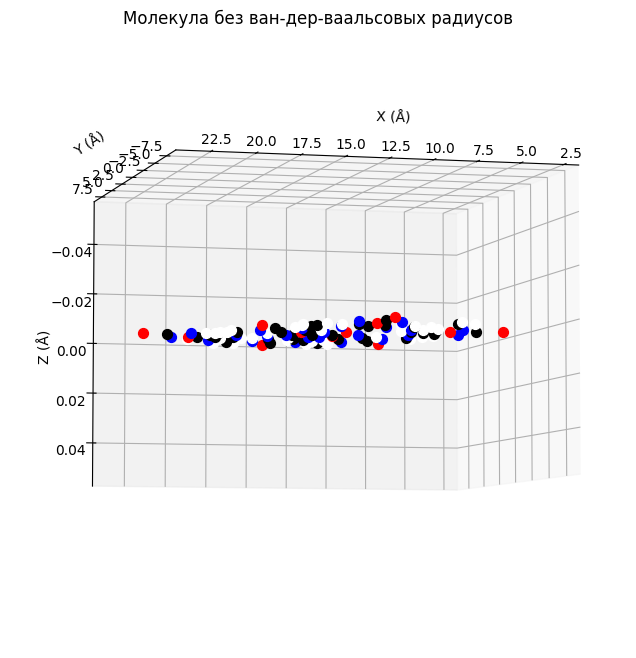

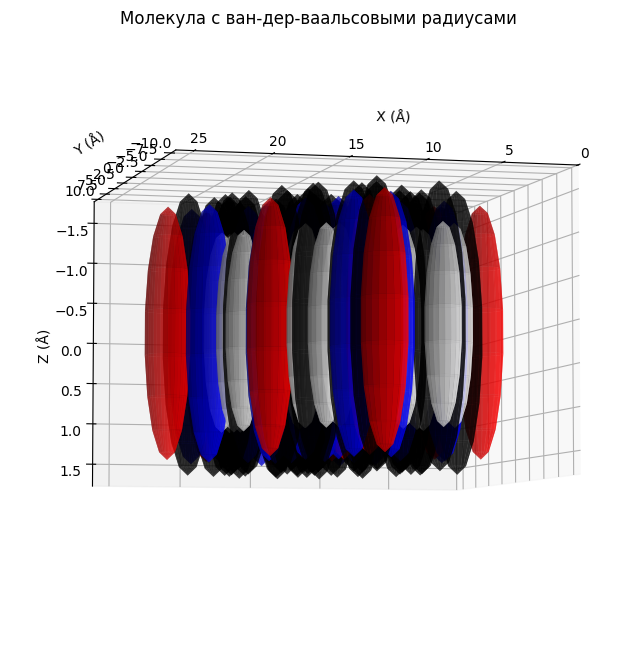

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 113768929  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 20  Error-roundoff 2.6e-14  _one-merge 1.8e-13
  _near-inside 9.1e-13  Visible-distance 5.2e-14  U-max-coplanar 5.2e-14
  Width-outside 1e-13  _wide-facet 3.1e-13  _maxoutside 2.1e-13

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p10(v4):    14   8.2     0
- p1(v3):    12  -8.2     0
- p8(v2):    23   3.1     0
- p5(v1):   3.1  -1.9     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 2.6e-14.  The center point, facets and distances
to the center point are as follows:

center point    13.06   0.2973        0

facet p1 p8 p5 distance=    0
facet p10 p8 p5 distance=    0
facet p10 p1 p5 distance=    0
facet p10 p1 p8 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:     3.084     22.99  difference= 19.9
  1:    -8.237     8.237  difference= 16.47
  2:         0         0  difference=    0

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 2.6e-14.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


In [9]:
vdw_radii = {
    'H': 1.2,
    'C': 1.7,
    'O': 1.52,
    'Br': 1.85,
    'S': 1.80,
    'N': 1.55
}

estimate_internal_volume('zz.txt', azim=105 , elev=175)


In [ ]:
def visualize_molecule_with_vdw(atoms, coords, azim=45, elev=30):
    """
    Визуализирует молекулу с ван-дер-ваальсовыми радиусами.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = {
        'H': 'white',
        'C': 'black',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'Br': 'brown'
    }

    for atom, coord in zip(atoms, coords):
        color = colors.get(atom, 'green')
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = coord[0] + radius * np.cos(u) * np.sin(v)
        y = coord[1] + radius * np.sin(u) * np.sin(v)
        z = coord[2] + radius * np.cos(v)
        ax.plot_surface(x, y, z, color=color, shade=True, alpha=0.6)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    plt.title('Молекула с ван-дер-ваальсовыми радиусами')

    ax.view_init(azim=azim, elev=elev)
    plt.show()

In [ ]:
def visualize_convex_hull(atoms, coords, hull, azim=45, elev=30):
    """
    Визуализирует молекулу с выпуклой оболочкой.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = {
        'H': 'white',
        'C': 'black',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'Br': 'brown'
    }

    for atom, coord in zip(atoms, coords):
        color = colors.get(atom, 'green')
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = coord[0] + radius * np.cos(u) * np.sin(v)
        y = coord[1] + radius * np.sin(u) * np.sin(v)
        z = coord[2] + radius * np.cos(v)
        ax.plot_surface(x, y, z, color=color, shade=True, alpha=0.6)

    simplices = hull.simplices
    for simplex in simplices:
        triangle = coords[simplex]
        tri = Poly3DCollection([triangle], facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.3)
        ax.add_collection3d(tri)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    plt.title('Молекула с выпуклой оболочкой')

    ax.view_init(azim=azim, elev=elev)
    plt.show()

In [ ]:
def visualize_cavity(atoms, coords, hull, azim=45, elev=30, num_points=1000000):
    """
    Визуализирует внутреннюю полость молекулы.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = {
        'H': 'white',
        'C': 'black',
        'O': 'red',
        'N': 'blue',
        'S': 'yellow',
        'Br': 'brown'
    }


    simplices = hull.simplices
    for simplex in simplices:
        triangle = coords[simplex]
        tri = Poly3DCollection([triangle], facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.2)
        ax.add_collection3d(tri)

    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    random_points = np.random.uniform(min_coords, max_coords, size=(num_points, 3))
    delaunay = Delaunay(coords[hull.vertices])
    inside_hull = delaunay.find_simplex(random_points) >= 0
    points_in_hull = random_points[inside_hull]

    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])
    coords_expanded = coords[:, np.newaxis, :]
    radii_expanded = atom_radii[:, np.newaxis]

    batch_size = 100000
    points_in_cavity = []

    for i in range(0, len(points_in_hull), batch_size):
        batch_points = points_in_hull[i:i+batch_size]
        batch_points_expanded = batch_points[np.newaxis, :, :]
        distances = np.linalg.norm(coords_expanded - batch_points_expanded, axis=2)
        inside_any_atom = np.any(distances <= radii_expanded, axis=0)
        cavity_points = batch_points[~inside_any_atom]
        points_in_cavity.append(cavity_points)

    points_in_cavity = np.concatenate(points_in_cavity, axis=0)

    ax.scatter(points_in_cavity[:, 0], points_in_cavity[:, 1], points_in_cavity[:, 2],
               color='magenta', s=1, alpha=0.6, label='Полость')

    for atom, coord in zip(atoms, coords):
        color = colors.get(atom, 'green')
        radius = vdw_radii.get(atom, 1.5)
        u, v = np.mgrid[0:2*np.pi:8j, 0:np.pi:4j]
        x = coord[0] + radius * np.cos(u) * np.sin(v)
        y = coord[1] + radius * np.sin(u) * np.sin(v)
        z = coord[2] + radius * np.cos(v)
        ax.plot_surface(x, y, z, color=color, shade=True, alpha=0.2)

    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    plt.title('Внутренняя полость молекулы')

    # Устанавливаем угол обзора
    ax.view_init(azim=azim, elev=elev)
    plt.legend()
    plt.show()


In [ ]:
def estimate_internal_volume(filename, azim=45, elev=30, num_points=1000000):
    atoms, coords = read_coordinates(filename)

    # 1. Молекула без ван-дер-ваальсовых радиусов
    visualize_molecule(atoms, coords, azim=azim, elev=elev)

    # 2. Молекула с ван-дер-ваальсовыми радиусами
    visualize_molecule_with_vdw(atoms, coords, azim=azim, elev=elev)

    # Вычисляем выпуклую оболочку
    hull = ConvexHull(coords)

    # 3. Молекула с выпуклой оболочкой
    visualize_convex_hull(atoms, coords, hull, azim=azim, elev=elev)

    # Оценка объема, занятого атомами внутри выпуклой оболочки
    min_coords = coords.min(axis=0)
    max_coords = coords.max(axis=0)
    random_points = np.random.uniform(min_coords, max_coords, size=(num_points, 3))
    delaunay = Delaunay(coords[hull.vertices])
    inside_hull = delaunay.find_simplex(random_points) >= 0
    points_in_hull = random_points[inside_hull]

    atom_radii = np.array([vdw_radii.get(atom, 1.5) for atom in atoms])
    coords_expanded = coords[:, np.newaxis, :]
    radii_expanded = atom_radii[:, np.newaxis]

    num_points_in_hull = len(points_in_hull)
    num_points_in_atoms = 0

    batch_size = 100000
    points_in_cavity = []

    for i in range(0, num_points_in_hull, batch_size):
        batch_points = points_in_hull[i:i+batch_size]
        batch_points_expanded = batch_points[np.newaxis, :, :]
        distances = np.linalg.norm(coords_expanded - batch_points_expanded, axis=2)
        inside_any_atom = np.any(distances <= radii_expanded, axis=0)
        num_points_in_atoms += np.sum(inside_any_atom)
        cavity_points = batch_points[~inside_any_atom]
        points_in_cavity.append(cavity_points)

    # Соединяем все точки в полости
    points_in_cavity = np.concatenate(points_in_cavity, axis=0)

    # Оцениваем объем, занимаемый атомами
    fraction_in_atoms = num_points_in_atoms / num_points_in_hull
    atom_volume = fraction_in_atoms * hull.volume

    # Вычисляем объем полости
    cavity_volume = hull.volume - atom_volume

    visualize_cavity(atoms, coords, hull, azim=azim, elev=elev, num_points=num_points)


    print(f"Объем выпуклой оболочки: {hull.volume:.2f} Å³")
    print(f"Оцененный объем внутренней полости: {cavity_volume:.2f} Å³")

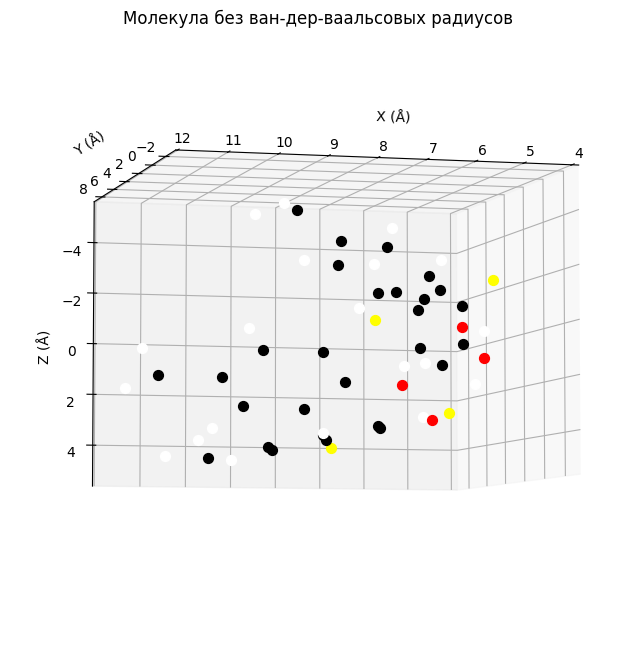

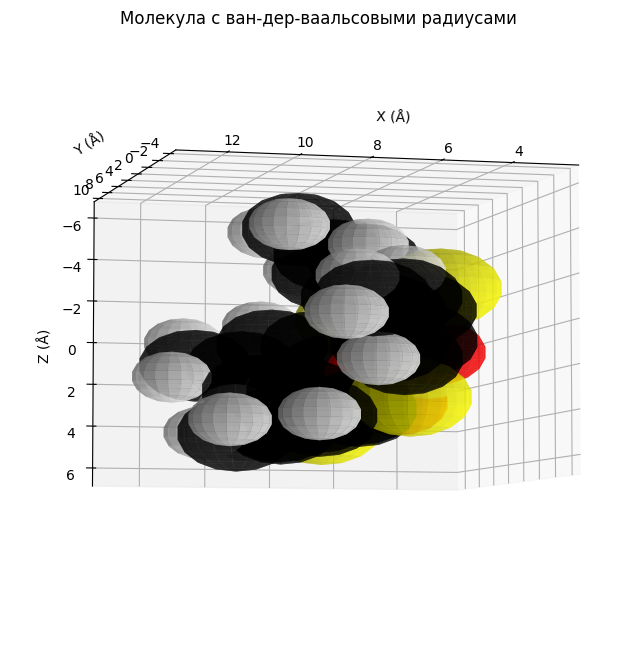

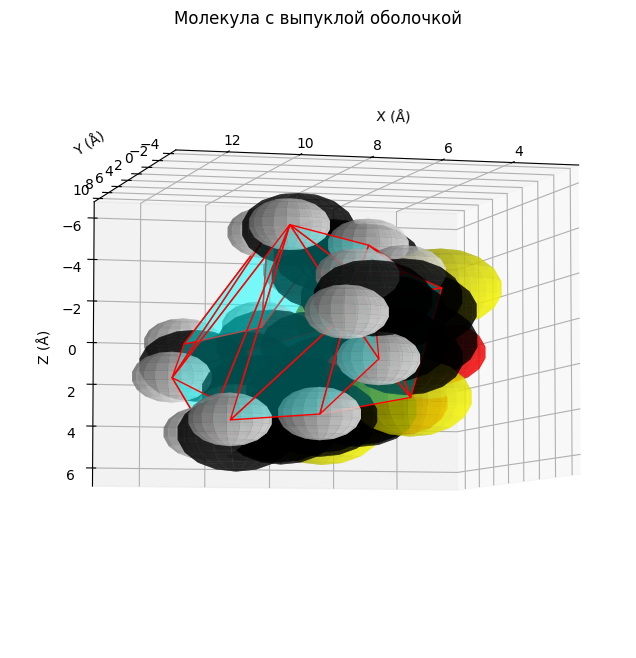

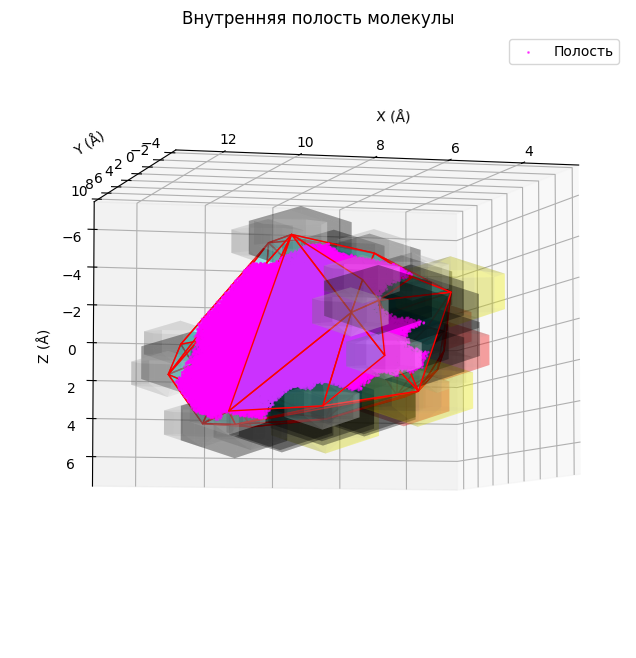

Объем выпуклой оболочки: 280.75 Å³
Оцененный объем, занимаемый атомами: 159.26 Å³
Оцененный объем внутренней полости: 121.49 Å³


In [ ]:
vdw_radii = {
    'H': 1.2,
    'C': 1.7,
    'O': 1.52,
    'Br': 1.85,
    'S': 1.80,
    'N': 1.55
}

estimate_internal_volume('/home/vinavolo/Documents/calicsaren/data/9.txt', azim=105 , elev=175)
